# 实验 v1.3

## 实验基本环境设置

In [2]:
# 导入依赖
import numpy as np
import pandas as pd
from rich import print
import matplotlib.pyplot as plt

In [3]:
# 字体设置
from pylab import mpl
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["Microsoft YaHei"]

## 自定义函数

In [7]:
# 导入自定义函数
%load_ext autoreload
%autoreload 2
from utils.helper import fairness_metrics, test_model # 测试各种指标并输出图像
from utils.shap_helper import get_ext_train_comp_by_k
from model.models import train_model_and_test
from mydata.adult import X_train, y_train, X_test, y_test, sex, feature_index # 获得 数据集 测试集 和 测试集上的敏感属性


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




## 超参设置

In [8]:
# 
seed = 1
np.random.seed(seed)

percent_k = 0.15
top_k = int(len(X_train) * percent_k)
"选取的样本数量是", top_k

('选取的样本数量是', 3418)

## 模型：逻辑回归

In [9]:
# 逻辑回归 - 训练
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(X_train, y_train)
# 逻辑回归 - 预测
y_pred = logreg.predict(X_test)
# 逻辑回归 - 指标
res_origin = fairness_metrics(y_test, y_pred, sex)

In [10]:
from sklearn.linear_model import ARDRegression

ard_origin, res_ard = train_model_and_test(
    X_train,
    y_train,
    X_test,
    y_test,
    test_func=test_model,
    sensitive_feature=sex,
    model_cls=ARDRegression,
    desc="ard测试组",
)

## XGBoost 原始数据

In [12]:
import xgboost


xgboost_origin, res_origin = train_model_and_test(
    X_train,
    y_train,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="原始组",
)

## XGBoost 优化组 + 对照组

In [13]:
(X_train_top, y_train_top), (X_train_rand, y_train_rand), shap_values = get_ext_train_comp_by_k(
    xgboost_origin, X_train, y_train, feature_index, top_k
)

[22:59:56] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[22:59:57] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [14]:
values = shap_values.values

In [15]:
xgboost_top, res_top = train_model_and_test(
    X_train_top,
    y_train_top,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="优化组",
)

In [16]:
xgboost_rand, res_rand = train_model_and_test(
    X_train_rand,
    y_train_rand,
    X_test,
    y_test,
    model_cls=xgboost.XGBRegressor,
    test_func=test_model,
    sensitive_feature=sex,
    desc="对照组",
)

## 数据分析

In [17]:
df = pd.DataFrame([res_origin, res_top, res_rand],index=["origin", "top-k", "rand-k"])
df

,准确率[1.],精确率[1.],召回率[1.],FPR[0.],FNR[0.],F1 Score[1.],人口平等 差异[0.],人口平等 比率[1.],机会均等 差异[0.],机会均等 比率[1.]
origin,0.861194,0.759979,0.621450,0.062483,0.378550,0.683769,0.172093,0.326185,0.084317,0.300440
top-k,0.864879,0.768753,0.629928,0.060324,0.370072,0.692451,0.169960,0.333731,0.084488,0.328424
rand-k,0.864469,0.764706,0.633743,0.062078,0.366257,0.693092,0.172897,0.330721,0.066044,0.288581


## 画图

adult-xgboost-shap-k=3418(15.0%)

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

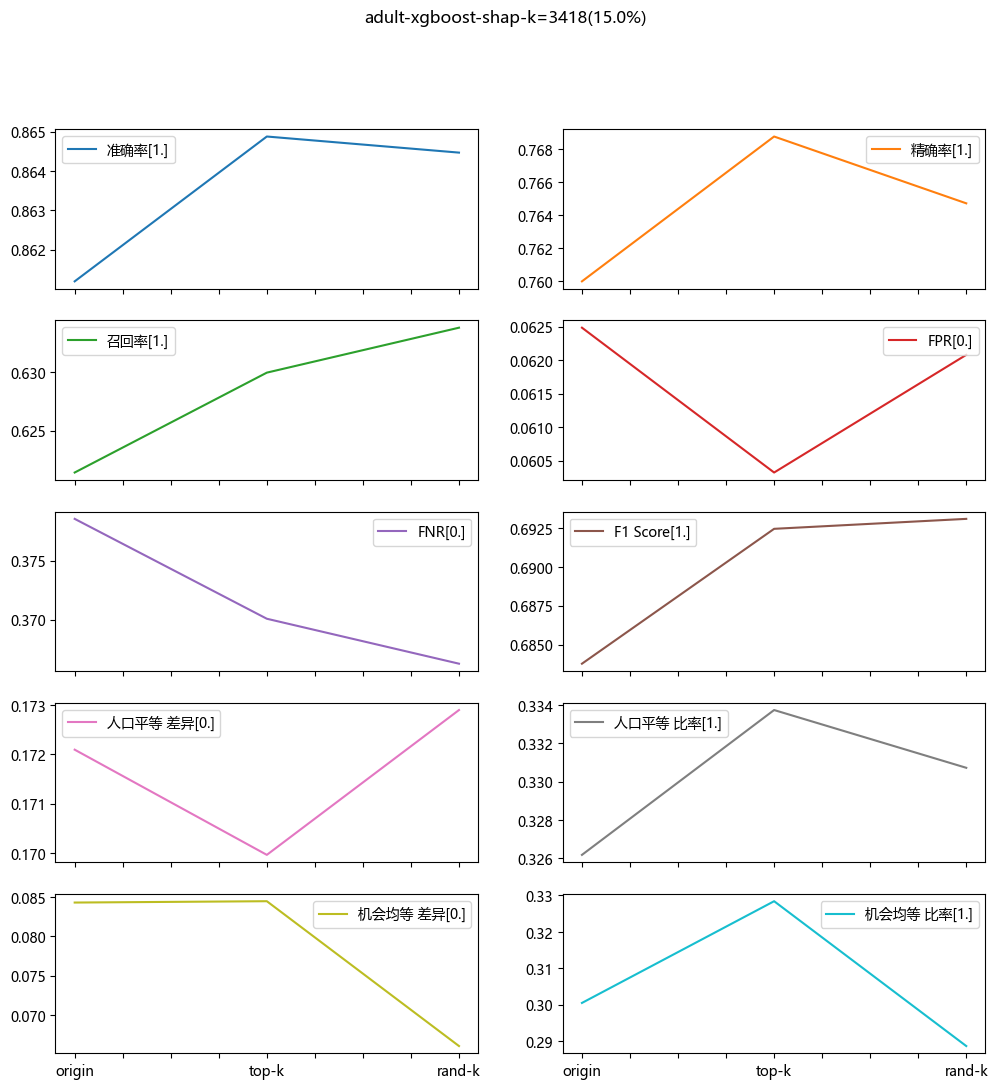

In [18]:
title = f"adult-xgboost-shap-k={top_k}({percent_k*100}%)"
print(title)
df.plot(
    title=title,
    subplots=True, 
    layout=(5, 2), 
    figsize=(12, 12), 
    kind='line',
)

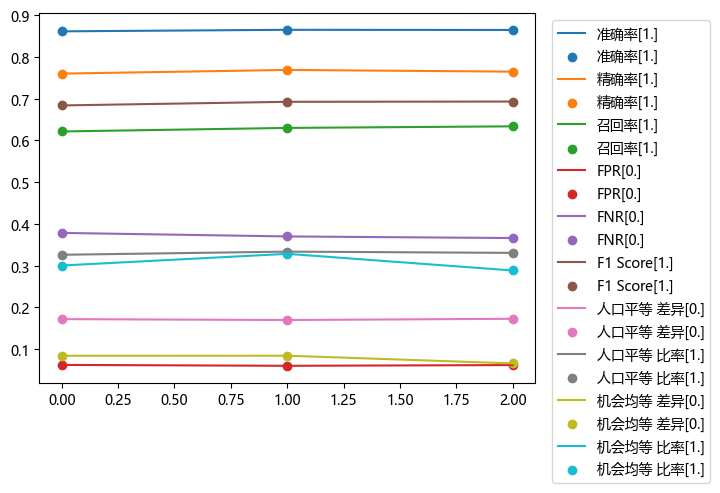

In [19]:
# 画在一张图上
cmap = plt.get_cmap('tab10')

for i, col in enumerate(df.columns):
    # print(i, col)
    values = df[col].values
    x = np.arange(len(values))
    
    plt.plot(x, values, label=col, color=cmap(i))
    plt.scatter(x, values, label=col, color=cmap(i))

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


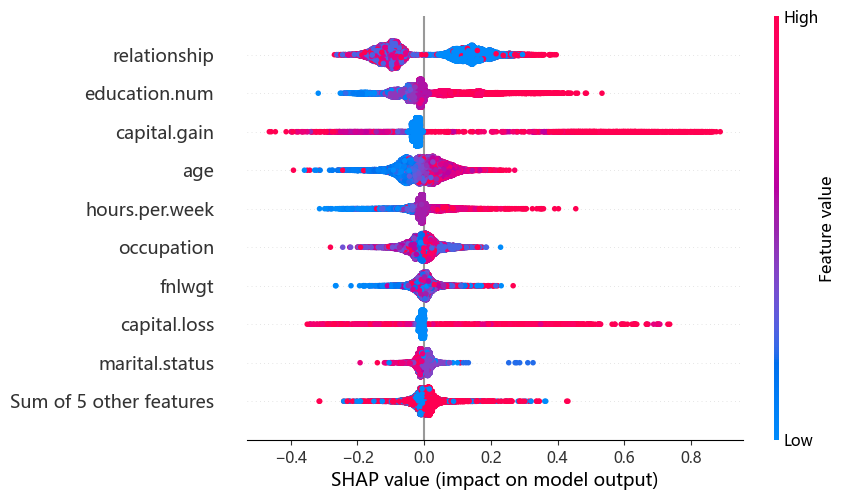

In [20]:
import shap
shap.plots.beeswarm(shap_values)

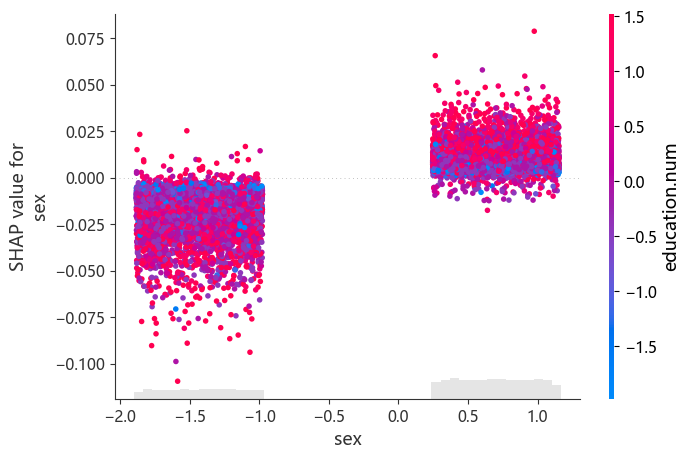

In [21]:
shap.plots.scatter(shap_values[:, "sex"], color=shap_values)